In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\path\to\your\local\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import RotatedSurfaceCode
from quantum_gates.utilities import SurfaceCode



Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


X-stab at qubit 1 (r=0, c=1) -> neighbors [6, 0, 2] -> data: [6, 0, 2]
X-stab at qubit 3 (r=0, c=3) -> neighbors [8, 2, 4] -> data: [8, 2, 4]
X-stab at qubit 11 (r=2, c=1) -> neighbors [6, 16, 10, 12] -> data: [6, 16, 10, 12]
X-stab at qubit 13 (r=2, c=3) -> neighbors [8, 18, 12, 14] -> data: [8, 18, 12, 14]
X-stab at qubit 21 (r=4, c=1) -> neighbors [16, 20, 22] -> data: [16, 20, 22]
X-stab at qubit 23 (r=4, c=3) -> neighbors [18, 22, 24] -> data: [18, 22, 24]
Z-stab at qubit 5 (r=1, c=0) -> neighbors [0, 10, 6] -> data: [0, 10, 6]
Z-stab at qubit 7 (r=1, c=2) -> neighbors [2, 12, 6, 8] -> data: [2, 12, 6, 8]
Z-stab at qubit 9 (r=1, c=4) -> neighbors [4, 14, 8] -> data: [4, 14, 8]
Z-stab at qubit 15 (r=3, c=0) -> neighbors [10, 20, 16] -> data: [10, 20, 16]
Z-stab at qubit 17 (r=3, c=2) -> neighbors [12, 22, 16, 18] -> data: [12, 22, 16, 18]
Z-stab at qubit 19 (r=3, c=4) -> neighbors [14, 24, 18] -> data: [14, 24, 18]
Parity-check matrix for X stabilizers built.
[[1 1 0 1 0 0 0 0 0 0 

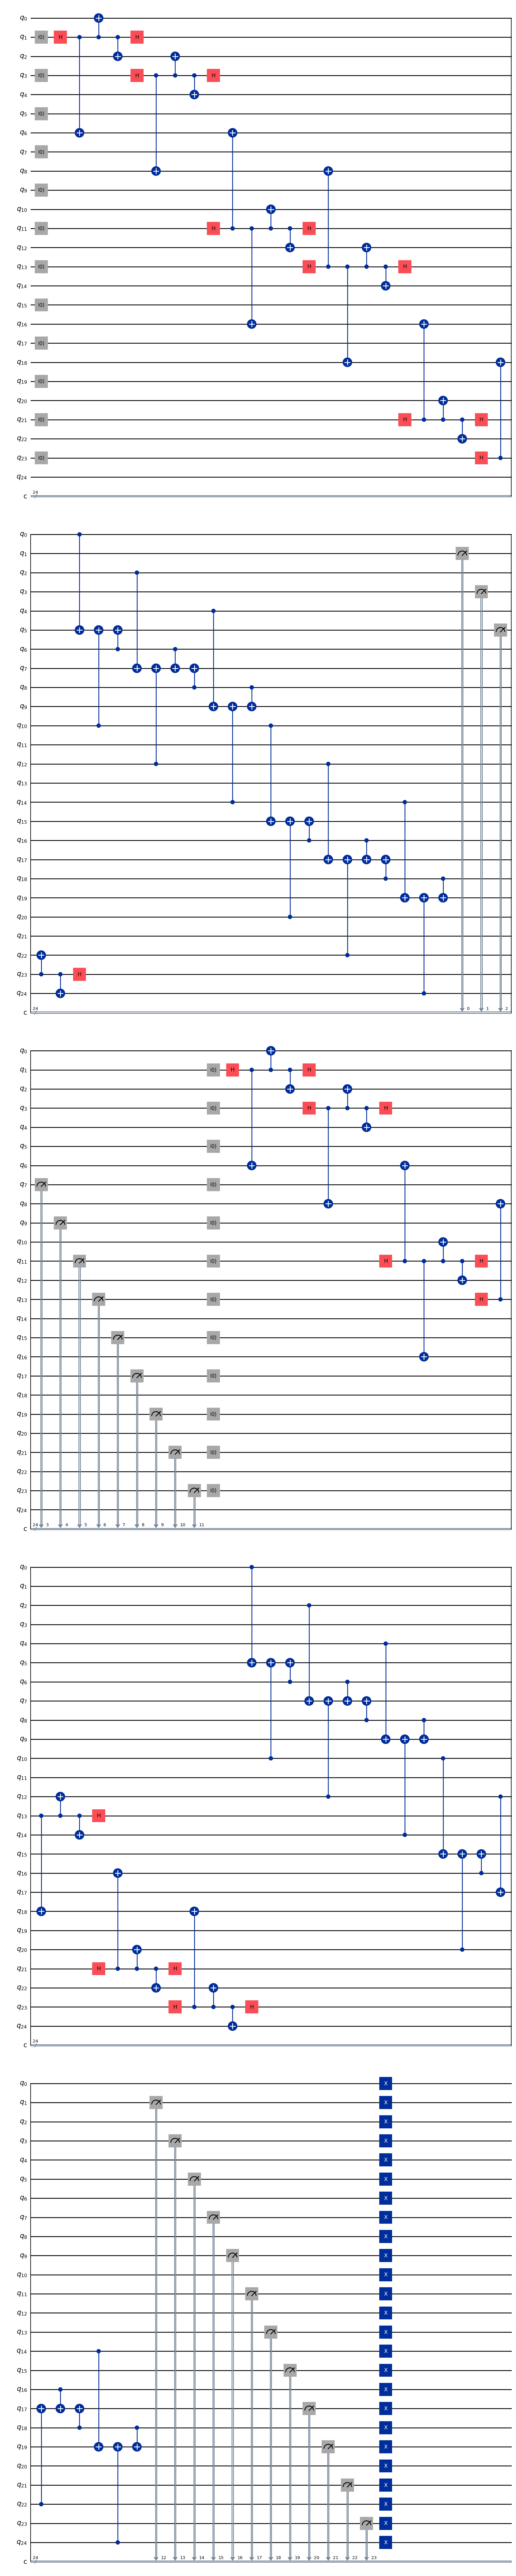

In [2]:

cycles=2
distance = 3

# build a Rotated Surface Code Circuit
code = SurfaceCode(distance=distance, cycles=cycles)
N_q = code.n_data + code.n_stabilizers
qc = code.qc
qc.x(range(N_q))
qc.draw('mpl', plot_barriers=False)

In [3]:
# call the simulator
#sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

# For Noise free simulation
from quantum_gates.gates import NoiseFreeGates 

sim = MrAndersonSimulator(
    gates=NoiseFreeGates,        # <- ideal gates (no noise)
    CircuitClass=EfficientCircuit
)


bit_flip_bool = False # turn on/off for readout noise

initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 10

In [4]:
# Pick a fake backend for device parameters
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

# 2) Use only N qubits
qubits_layout = list(range(N_q))

# 3) Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
#device_param.save_to_json("./")  # writes ./device_parameters.json
#print("Wrote ./device_parameters.json")

In [5]:
from itertools import combinations
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import (
    XGate, SXGate, RZGate, Reset, Measure
)
from qiskit.circuit.library.standard_gates import ECRGate, CXGate
from qiskit.circuit import Delay


def build_custom_target(num_q):
    target = Target(num_qubits=num_q)

    # -------------------------
    # Single-qubit gates
    # -------------------------
    single_qubit_gates = {
        "x": XGate(),
        "sx": SXGate(),
        "rz": RZGate(0.0),
        "reset": Reset(),
        "measure": Measure(),
    }

    for gate in single_qubit_gates.values():
        props = {(q,): InstructionProperties() for q in range(num_q)}
        target.add_instruction(gate, props)

    # -------------------------
    # Delay instruction
    # -------------------------
    delay_gate = Delay(1)   # duration placeholder
    props = {(q,): InstructionProperties() for q in range(num_q)}
    target.add_instruction(delay_gate, props)

    # -------------------------
    # ECR gate (full connectivity)
    # -------------------------
    ecr_props = {
        (i, j): InstructionProperties()
        for i in range(num_q)
        for j in range(num_q)
        if i != j
    }
    target.add_instruction(ECRGate(), ecr_props)

    # -------------------------
    # CX gate (full connectivity)
    # -------------------------
    cx_props = {
        (i, j): InstructionProperties()
        for i in range(num_q)
        for j in range(num_q)
        if i != j
    }
    target.add_instruction(CXGate(), cx_props)

    return target


In [6]:
target = build_custom_target(N_q)

In [7]:
# Transpile circuit
needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)
'''
t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)
'''
t_circ = transpile(
    qc,
    target=target,
    initial_layout=list(range(N_q)),
    layout_method="trivial",
    routing_method="sabre",
    optimization_level=2,
    seed_transpiler=42
)


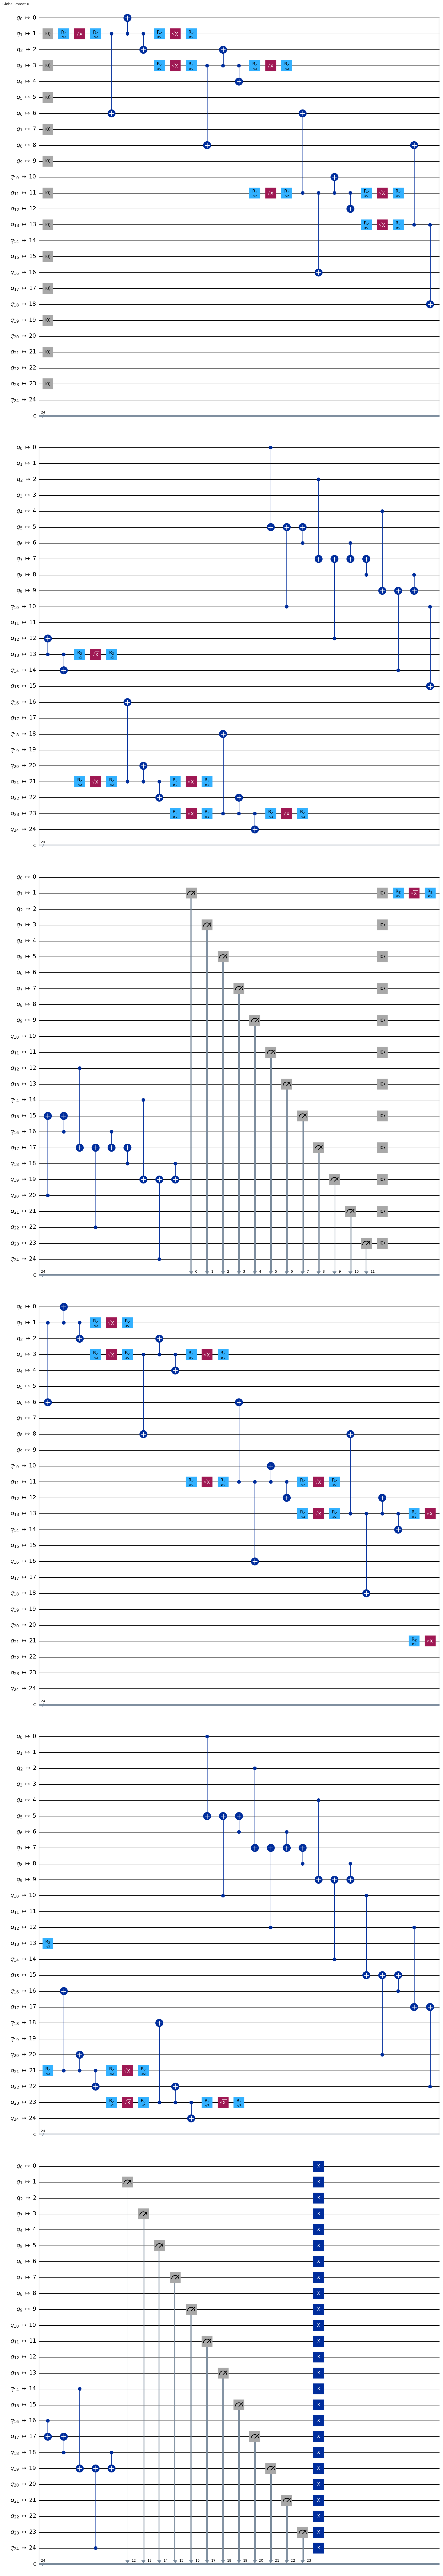

In [8]:
t_circ.draw('mpl', plot_barriers=False)

In [ ]:

# Run simulation
res  = sim.run( 
    t_qiskit_circ=t_circ, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

# get results
probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
measured_statevetors = res["statevector_readout"]
mid_counts = res["mid_counts"]


#print("Mid-circuit measurement results", results)
#print("statevectors of measures:", measured_statevetors)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

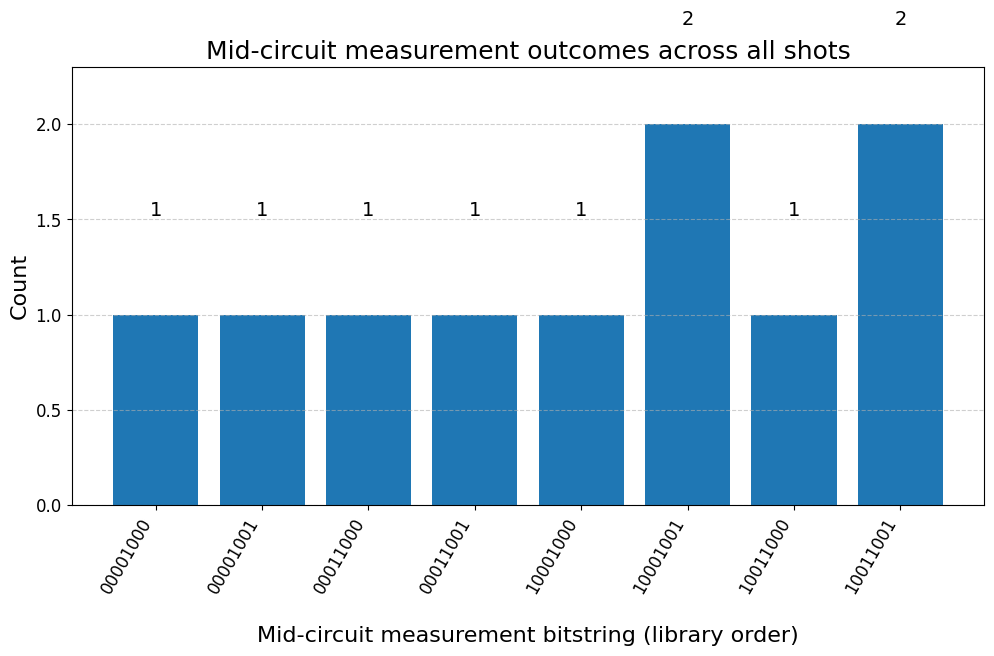

Mid-circuit measurement counts: {'10001000': 1, '00001000': 1, '00011000': 1, '10001001': 2, '00011001': 1, '00001001': 1, '10011001': 2, '10011000': 1}


In [ ]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

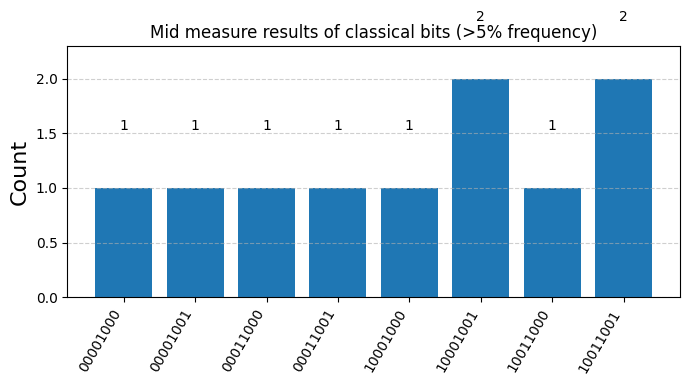

In [ ]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

In [ ]:
# Simulate with Aer
sim = AerSimulator()
#t_qc = transpile(qc, sim)
result = sim.run(qc, shots=1000).result()
counts = result.get_counts()

Aer All clbits counts: {'10001000': 244, '10011001': 226, '00000000': 251, '00010001': 279}


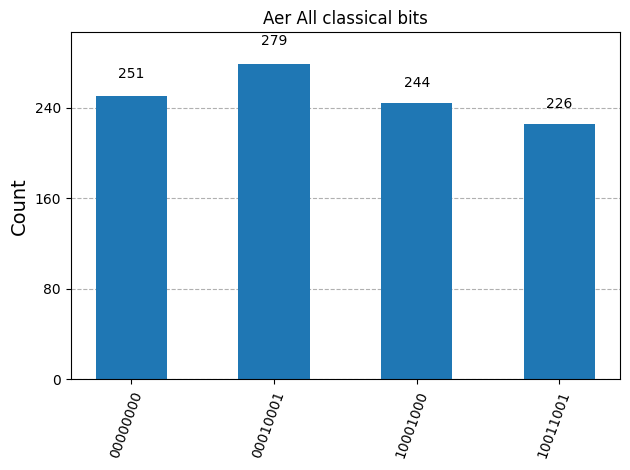

In [ ]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")